importing libraries

In [1]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
import numpy as np
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

[nltk_data] Downloading package wordnet to C:\Users\Zahra's
[nltk_data]     computer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


reading csv files

In [2]:
df = pd.read_csv(r"C:/Users/Zahra's computer/Desktop/all_sources_metadata_2020-03-13.csv", encoding='utf-8')


preprocessing data such as deleting stop words and etc

In [3]:

selected_columns = ['publish_time', 'title', 'abstract']
df_selected = df[selected_columns]
df_selected = df_selected.drop_duplicates()
df_selected = df_selected.dropna()
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    words = text.split()
    words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
    words = [porter.stem(word) for word in words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)
df_selected['title'] = df_selected['title'].apply(preprocess_text)
df_selected['abstract'] = df_selected['abstract'].apply(preprocess_text)
print(df_selected.head())

  publish_time                                              title  \
2         2020  incub period epidemiolog characterist novel co...   
3         2020  characterist public health respons coronaviru ...   
5         2020        updat estim risk transmiss novel coronaviru   
6         2020            forecast epidem china februari februari   
8         2020  outbreak diamond princess cruis estim epidem p...   

                                            abstract  
2  geograph spread novel coronaviru infect epicen...  
3  decemb case unidentifi pneumonia histori expos...  
5  basic reproduct number infecti agent averag nu...  
6  initi cluster sever pneumonia case trigger epi...  
8  cruis ship carri larg number peopl confin spac...  


saving in new csv file

In [4]:
df_selected.to_csv("C:/Users/Zahra's computer/Desktop/preprocessed1_data.csv", index=False)

feature_extraction by tf_idf

In [5]:

df_selected['text_combined'] = df_selected['title'] + ' ' + df_selected['abstract']
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X_tfidf = vectorizer.fit_transform(df_selected['text_combined'])
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
df_selected = pd.concat([df_selected, df_tfidf], axis=1)
df_selected = df_selected.drop('text_combined', axis=1)
print(df_selected.head())


  publish_time                                              title  \
2         2020  incub period epidemiolog characterist novel co...   
3         2020  characterist public health respons coronaviru ...   
5         2020        updat estim risk transmiss novel coronaviru   
6         2020            forecast epidem china februari februari   
8         2020  outbreak diamond princess cruis estim epidem p...   

                                            abstract  abil  abl     acid  \
2  geograph spread novel coronaviru infect epicen...   0.0  0.0  0.00000   
3  decemb case unidentifi pneumonia histori expos...   0.0  0.0  0.00000   
5  basic reproduct number infecti agent averag nu...   0.0  0.0  0.27261   
6  initi cluster sever pneumonia case trigger epi...   0.0  0.0  0.00000   
8  cruis ship carri larg number peopl confin spac...   0.0  0.0  0.00000   

   activ      acut     adapt     addit  ...     virus  vitro  vivo  week  \
2    0.0  0.000000  0.000000  0.000000  ...  0.00000

word2vec

In [6]:

def tokenize_text(text):
    if isinstance(text, str):
        return word_tokenize(text)
    else:
        return []
df_selected['title_tokens'] = df_selected['title'].apply(tokenize_text)
df_selected['abstract_tokens'] = df_selected['abstract'].apply(tokenize_text)
df_selected['text_tokens'] = df_selected['title_tokens'] + df_selected['abstract_tokens']
word2vec_model = Word2Vec(sentences=df_selected['text_tokens'], vector_size=100, window=5, min_count=1, workers=4)
def calculate_average_vector(tokens, model):
    vector_sum = np.zeros(model.vector_size)
    count = 0
    for word in tokens:
        if word in model.wv:
            vector_sum += model.wv[word]
            count += 1
    if count == 0:
        return np.zeros(model.vector_size)
    return vector_sum / count
df_selected['word2vec_features'] = df_selected['text_tokens'].apply(lambda x: calculate_average_vector(x, word2vec_model))
df_word2vec = pd.DataFrame(df_selected['word2vec_features'].tolist(), columns=[f'word2vec_{i}' for i in range(100)])
df_selected = pd.concat([df_selected, df_word2vec], axis=1)
df_selected = df_selected.drop(['title_tokens', 'abstract_tokens', 'text_tokens', 'word2vec_features'], axis=1)
print(df_selected.head())


  publish_time                                              title  \
2         2020  incub period epidemiolog characterist novel co...   
3         2020  characterist public health respons coronaviru ...   
5         2020        updat estim risk transmiss novel coronaviru   
6         2020            forecast epidem china februari februari   
8         2020  outbreak diamond princess cruis estim epidem p...   

                                            abstract  abil  abl     acid  \
2  geograph spread novel coronaviru infect epicen...   0.0  0.0  0.00000   
3  decemb case unidentifi pneumonia histori expos...   0.0  0.0  0.00000   
5  basic reproduct number infecti agent averag nu...   0.0  0.0  0.27261   
6  initi cluster sever pneumonia case trigger epi...   0.0  0.0  0.00000   
8  cruis ship carri larg number peopl confin spac...   0.0  0.0  0.00000   

   activ      acut     adapt     addit  ...  word2vec_90  word2vec_91  \
2    0.0  0.000000  0.000000  0.000000  ...    -0.28905

bow

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd
df_selected['text_combined'] = df_selected['title'] + ' ' + df_selected['abstract']
df_selected['text_combined'] = df_selected['text_combined'].fillna('')
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X_tfidf = tfidf_vectorizer.fit_transform(df_selected['text_combined'])
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
bow_vectorizer = CountVectorizer(stop_words='english', max_features=500)
X_bow = bow_vectorizer.fit_transform(df_selected['text_combined'])
df_bow = pd.DataFrame(X_bow.toarray(), columns=bow_vectorizer.get_feature_names_out())
df_selected = pd.concat([df_selected, df_tfidf, df_bow], axis=1)
df_selected = df_selected.drop('text_combined', axis=1)
print(df_selected.head())


  publish_time                                              title  \
2         2020  incub period epidemiolog characterist novel co...   
3         2020  characterist public health respons coronaviru ...   
5         2020        updat estim risk transmiss novel coronaviru   
6         2020            forecast epidem china februari februari   
8         2020  outbreak diamond princess cruis estim epidem p...   

                                            abstract  abil  abl     acid  \
2  geograph spread novel coronaviru infect epicen...   0.0  0.0  0.00000   
3  decemb case unidentifi pneumonia histori expos...   0.0  0.0  0.00000   
5  basic reproduct number infecti agent averag nu...   0.0  0.0  0.27261   
6  initi cluster sever pneumonia case trigger epi...   0.0  0.0  0.00000   
8  cruis ship carri larg number peopl confin spac...   0.0  0.0  0.00000   

   activ      acut     adapt     addit  ...  virus  vitro  vivo  week  wherea  \
2    0.0  0.000000  0.000000  0.000000  ...    

lda

In [8]:
df_selected['combined_text'] = df_selected['title'] + ' ' + df_selected['abstract']
df_selected['combined_text'] = df_selected['combined_text'].fillna('')
vectorizer = CountVectorizer(min_df=2, stop_words='english')
X_text_counts = vectorizer.fit_transform(df_selected['combined_text'])
# Apply LDA
num_topics = 5  
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
X_topics = lda.fit_transform(X_text_counts)
feature_names = vectorizer.get_feature_names_out()
topic_names = [f"Topic {i}" for i in range(num_topics)]
df_topics = pd.DataFrame(lda.components_, columns=feature_names, index=topic_names)

for topic in range(num_topics):
    top_words_idx = df_topics.iloc[topic].values.argsort()[:-10-1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic {topic}: {', '.join(top_words)}")
df_selected = pd.concat([df_selected, pd.DataFrame(X_topics, columns=topic_names)], axis=1)
df_selected = df_selected.drop(['combined_text'], axis=1)
print(df_selected.head())


Topic 0: viru, sequenc, virus, detect, human, infect, genom, strain, sampl, viral
Topic 1: protein, use, viral, rna, viru, cell, vaccin, gene, structur, target
Topic 2: cell, infect, activ, viru, immun, respons, express, viral, effect, induc
Topic 3: patient, respiratori, infect, case, clinic, studi, sever, hospit, use, coronaviru
Topic 4: health, diseas, use, public, model, data, outbreak, emerg, infecti, studi
  publish_time                                              title  \
2         2020  incub period epidemiolog characterist novel co...   
3         2020  characterist public health respons coronaviru ...   
5         2020        updat estim risk transmiss novel coronaviru   
6         2020            forecast epidem china februari februari   
8         2020  outbreak diamond princess cruis estim epidem p...   

                                            abstract  abil  abl     acid  \
2  geograph spread novel coronaviru infect epicen...   0.0  0.0  0.00000   
3  decemb case un

In [9]:
df_selected.to_csv("C:/Users/Zahra's computer/Desktop/df_with_topics.csv", index=False)

pca

In [10]:
num_pca_components = 3  

# Apply PCA
pca = PCA(n_components=num_pca_components, random_state=42)
X_topics_pca = pca.fit_transform(X_topics)
pca_columns = [f"PCA_{i+1}" for i in range(num_pca_components)]
df_pca = pd.DataFrame(X_topics_pca, columns=pca_columns)
df_selected = pd.concat([df_selected, df_pca], axis=1)
print(df_selected.head())


  publish_time                                              title  \
2         2020  incub period epidemiolog characterist novel co...   
3         2020  characterist public health respons coronaviru ...   
5         2020        updat estim risk transmiss novel coronaviru   
6         2020            forecast epidem china februari februari   
8         2020  outbreak diamond princess cruis estim epidem p...   

                                            abstract  abil  abl     acid  \
2  geograph spread novel coronaviru infect epicen...   0.0  0.0  0.00000   
3  decemb case unidentifi pneumonia histori expos...   0.0  0.0  0.00000   
5  basic reproduct number infecti agent averag nu...   0.0  0.0  0.27261   
6  initi cluster sever pneumonia case trigger epi...   0.0  0.0  0.00000   
8  cruis ship carri larg number peopl confin spac...   0.0  0.0  0.00000   

   activ      acut     adapt     addit  ...  year  zoonot   Topic 0   Topic 1  \
2    0.0  0.000000  0.000000  0.000000  ...   0

elbow mwthod and kmeans and dbscan Agglomerative

d:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._chec

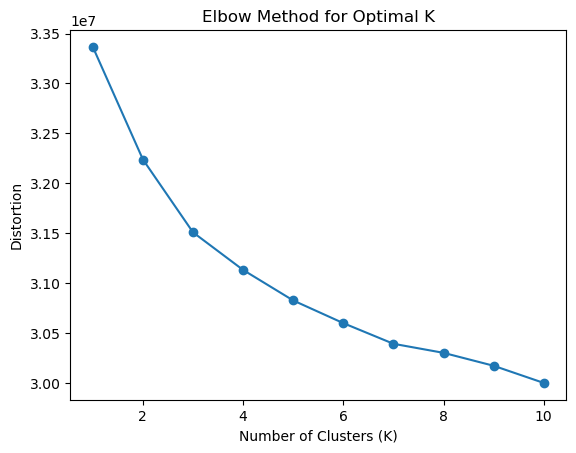

d:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans Silhouette Score: 0.19745553787971157
Agglomerative Silhouette Score: 0.19239854205624768
DBSCAN Silhouette Score: 0.1854584761082675
  publish_time                                              title  \
2         2020  incub period epidemiolog characterist novel co...   
3         2020  characterist public health respons coronaviru ...   
5         2020        updat estim risk transmiss novel coronaviru   
6         2020            forecast epidem china februari februari   
8         2020  outbreak diamond princess cruis estim epidem p...   

                                            abstract  abil  abl     acid  \
2  geograph spread novel coronaviru infect epicen...   0.0  0.0  0.00000   
3  decemb case unidentifi pneumonia histori expos...   0.0  0.0  0.00000   
5  basic reproduct number infecti agent averag nu...   0.0  0.0  0.27261   
6  initi cluster sever pneumonia case trigger epi...   0.0  0.0  0.00000   
8  cruis ship carri larg number peopl confin spac...   0.0  0.0 

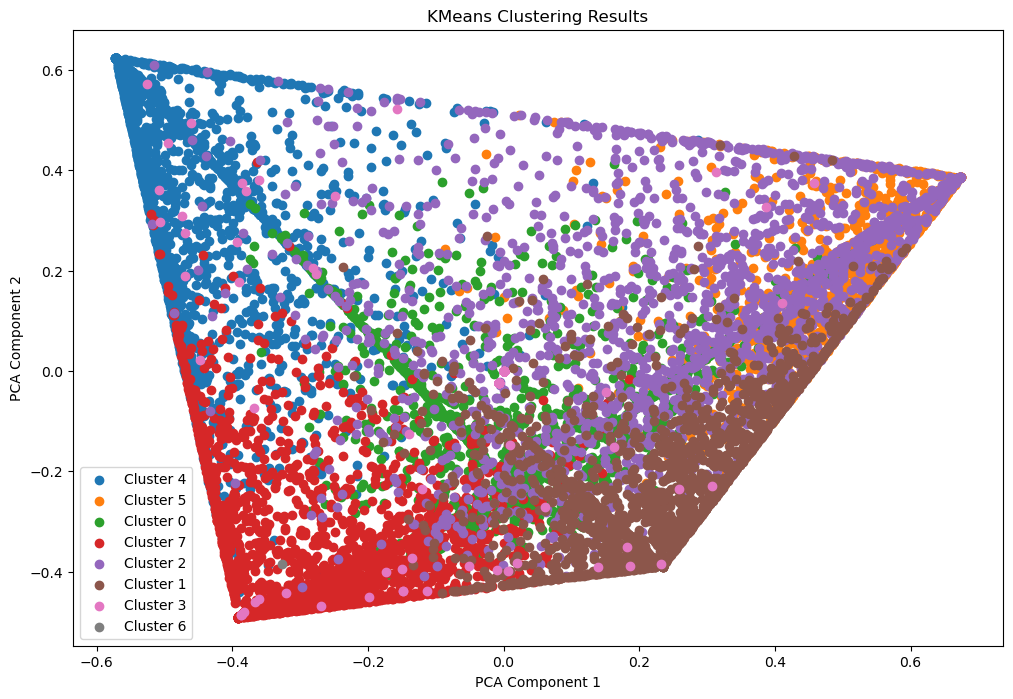

In [13]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
df_selected.fillna(0, inplace=True)
features = df_selected.iloc[:, 3:]  
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)
distortions = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(features_standardized)
    distortions.append(kmeans.inertia_)

plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal K')
plt.show()
=
optimal_k = 8

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_selected['kmeans_labels'] = kmeans.fit_predict(features_standardized)
kmeans_silhouette = silhouette_score(features_standardized, df_selected['kmeans_labels'])
print(f"KMeans Silhouette Score: {kmeans_silhouette}")

agg_clustering = AgglomerativeClustering(n_clusters=optimal_k)
df_selected['agg_labels'] = agg_clustering.fit_predict(features_standardized)
agg_silhouette = silhouette_score(features_standardized, df_selected['agg_labels'])
print(f"Agglomerative Silhouette Score: {agg_silhouette}")
=
dbscan = DBSCAN(eps=0.5, min_samples=8)
df_selected['dbscan_labels'] = dbscan.fit_predict(features_standardized)
dbscan_silhouette = silhouette_score(features_standardized, df_selected['dbscan_labels'])
print(f"DBSCAN Silhouette Score: {dbscan_silhouette}")

print(df_selected.head())

df_selected['kmeans_labels'] = pd.to_numeric(df_selected['kmeans_labels'], errors='coerce')

plt.figure(figsize=(12, 8))

for label in df_selected['kmeans_labels'].unique():
    cluster_data = df_selected[df_selected['kmeans_labels'] == label]
    plt.scatter(cluster_data[f'PCA_1'], cluster_data[f'PCA_2'], label=f'Cluster {label}')

plt.title('KMeans Clustering Results')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()                

و با استفاده از رنگ های مختلف خوشه ی هر داده را مشخص 5 داده ها را به صورت دو بعدی نمایش دهید 
کنید.

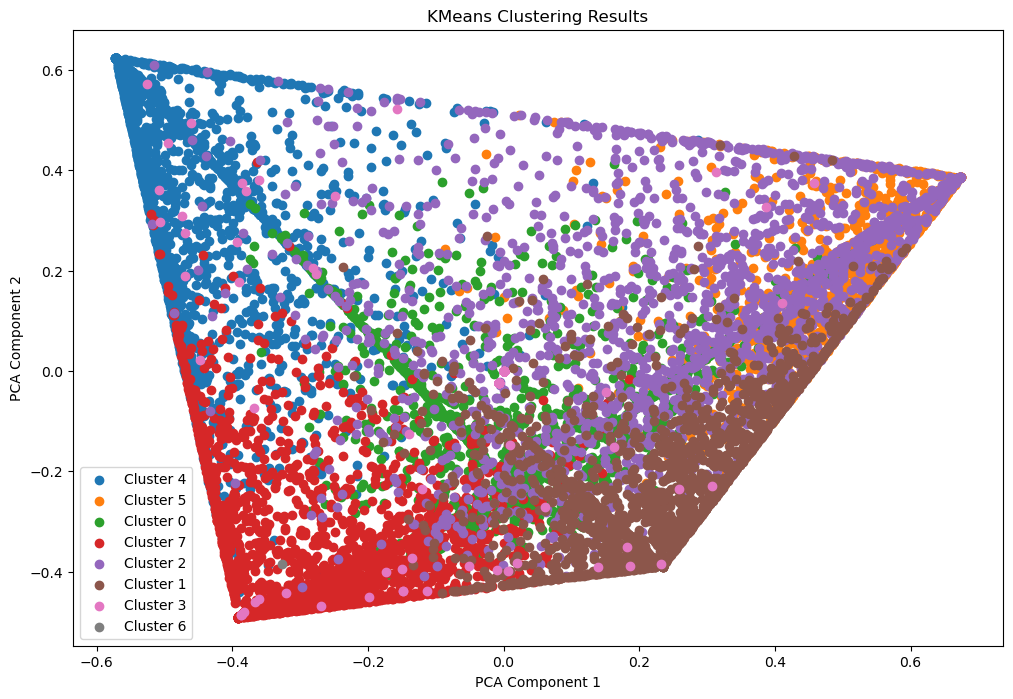

In [14]:
plt.figure(figsize=(12, 8))

for label in df_selected['kmeans_labels'].unique():
    cluster_data = df_selected[df_selected['kmeans_labels'] == label]
    plt.scatter(cluster_data[f'PCA_1'], cluster_data[f'PCA_2'], label=f'Cluster {label}')

plt.title('KMeans Clustering Results')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


با بررسی خوشه ها تحلیل کنید که هر خوشه نماینده ی کدام نوع از موضوعات می باشند.

In [ ]:


for cluster in range(optimal_k):
    top_features_idx = df_selected[df_selected['kmeans_labels'] == cluster].iloc[:, -num_pca_components:].mean().argsort()[:-5-1:-1]
    top_features = df_selected.columns[-num_pca_components:][top_features_idx]
    print(f"Cluster {cluster} Top Features: {', '.join(top_features)}")


Cluster 0 Top Features: PCA_3, PCA_1, PCA_2
Cluster 1 Top Features: PCA_3, PCA_1, PCA_2
Cluster 2 Top Features: PCA_2, PCA_3, PCA_1
Cluster 3 Top Features: PCA_1, PCA_3, PCA_2
Cluster 4 Top Features: PCA_3, PCA_1, PCA_2
Cluster 5 Top Features: PCA_2, PCA_3, PCA_1
Cluster 6 Top Features: PCA_1, PCA_2, PCA_3
Cluster 7 Top Features: PCA_3, PCA_1, PCA_2


optics

In [ ]:
from sklearn.cluster import OPTICS, KMeans
from sklearn.metrics import silhouette_score
optics = OPTICS(min_samples=5)
df_selected['optics_labels'] = optics.fit_predict(features_standardized)
silhouette_optics = silhouette_score(features_standardized, df_selected['optics_labels'])
print(f'Silhouette score for OPTICS: {silhouette_optics}')


KeyboardInterrupt: 